In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D
from scipy.stats import ttest_rel

In [2]:
def add_label_to_df(df, path_to_labels):
    """Add label description to the input dataframe."""
    if Path(path_to_labels).is_dir():
        series_to_labels_mapping = {}
        for path in Path(path_to_labels).glob('*.json'):
            with open(path, 'r') as file:
                labels = json.load(file)
                series_to_labels_mapping.update({
                    f"{path.stem}": labels
                })
    elif Path(path_to_labels).is_file():
        with open(path_to_labels, 'r') as file:
            series_to_labels_mapping = json.load(file)
    else:
        raise ValueError(f"path_to_labels ''{path_to_labels}' must be file or directory'")
    labels_mapping_list = [
        {
            "series_uuid": series,
            "foreground_label": int(value),
            "label_description": ','.join([value_.lower().strip() for value_ in label.split(',')])
        }
        for series, mapping in series_to_labels_mapping.items()
        for value, label in mapping.items()
    ]
    labels_mapping_df = pd.DataFrame(labels_mapping_list)
    new_df = df.copy()
    new_df["series_uuid"] = new_df["ct_fname"].apply(lambda x: x.split('.nii.gz')[0])
    merged_df = new_df.merge(labels_mapping_df, on=["series_uuid", "foreground_label"], how='left')
    return merged_df

In [3]:
def add_patient_info_to_df(df, path_to_patients, path_to_series):
    """Add patient information to each row of the input dataframe.

    Parameters
    ----------
    df : pd dataframe
        Input dataframe containing performance for each bounding box.
    path_to_patients : str
        Path to the 'patients.csv' file containing patient id columns
        'id_proyecto', 'code', 'sexo', 'edad', 'diagnóstico'.
    path_to_series : str
        Path to the 'series.json' containing series metadata.
    """
    patient_columns_mapping = {
        'id_proyecto': 'patient_id',
        'code': 'patient_code',
        'sexo': 'sex',
        'edad': 'age',
        'diagnóstico': 'diagnosis'        
    }
    patients_df = pd.read_csv(path_to_patients)
    with open(path_to_series, 'r') as file:
        series_df = pd.DataFrame(json.load(file))
    series_df['patient_code'] = series_df['patient_code'].astype('int64')
    series_df = pd.merge(
        series_df,
        patients_df[patient_columns_mapping.keys()],
        left_on='patient_code',
        right_on='code',
        how='inner'       
    )
    series_df.drop(columns=['patient_code', 'patient_id'], inplace=True)
    series_df.rename(columns=patient_columns_mapping, inplace=True)
    output_df = pd.merge(
        df,
        series_df[list(patient_columns_mapping.values()) + ['uuid']],
        left_on='study',
        right_on='uuid',
        how='inner'
    )
    output_df.drop(columns=['uuid'], inplace=True)
    return output_df

In [4]:
def concatenate_iteration_dfs(iteration_dfs, keep_only_common_between_iterations=True):
    """Return concatenated dataframes with the column 'iteration'
    added.

    Parameters
    ----------
    iteration_dfs : list
        Each item is a dictionary with the following keys:
            'path': path to the performance JSON file.
            'iteration': integer indicating the iteration.
    keep_only_common_between_iterations : bool, optional
        Remove rows with bounding boxes that are absent in at least one iteration.
        The resulting dataframe has rows with bounding boxes present in all iterations.
    """
    dfs = []
    for item in iteration_dfs:
        with open(item['path'], 'r') as file:
            df = pd.DataFrame(json.load(file)['bboxes'])
        df['iteration'] = item['iteration']
        dfs.append(df)
    concatenated_df = pd.concat(dfs, ignore_index=True).sort_values(by='iteration')
    if keep_only_common_between_iterations:
        common_bboxes = set(concatenated_df['bbox_original_fname'])
        for iteration in concatenated_df['iteration'].unique():
            common_bboxes = common_bboxes.intersection(set(concatenated_df[concatenated_df['iteration'] == iteration]['bbox_original_fname']))
        concatenated_df = concatenated_df[concatenated_df['bbox_original_fname'].isin(common_bboxes)]
    return concatenated_df

In [5]:
def run_paired_t_test(performance_df, iteration_a = 0, iteration_b = 1):
    "Test the difference between the means of both iterations (iteration_b - iteration_a)."
    performance_df_subset = performance_df[(performance_df['iteration'] == iteration_a) | (performance_df['iteration'] == iteration_b)].copy()
    duplicated = performance_df_subset['bbox_original_fname'].duplicated(keep=False)
    filtered = performance_df_subset[duplicated]
    filtered_a = filtered[filtered['iteration'] == iteration_a].copy()
    filtered_b = filtered[filtered['iteration'] == iteration_b].copy()
    filtered_a.sort_values(by='bbox_original_fname', inplace=True)
    filtered_b.sort_values(by='bbox_original_fname', inplace=True)
    new_df = {
        f"index_iteration_{iteration_a}": filtered_a.index.to_list(),
        f"bbox_original_fname_iteration_{iteration_a}": filtered_a['bbox_original_fname'].to_list(),
        f"dice_score_iteration_{iteration_a}": filtered_a['dice_score'].to_list(),
        f"index_iteration_{iteration_b}": filtered_b.index.to_list(),
        f"bbox_original_fname_iteration_{iteration_b}": filtered_b['bbox_original_fname'].to_list(),
        f"dice_score_iteration_{iteration_b}": filtered_b['dice_score'].to_list()
    }
    new_df = pd.DataFrame(new_df)
    new_df['paired_sample'] = new_df.apply(
        lambda row: row[f"bbox_original_fname_iteration_{iteration_a}"] == row[f"bbox_original_fname_iteration_{iteration_b}"],
        axis=1
    )
    new_df['difference'] = new_df[f"dice_score_iteration_{iteration_a}"] - new_df[f"dice_score_iteration_{iteration_b}"]
    ttest_result = ttest_rel(
        new_df[f"dice_score_iteration_{iteration_b}"],
        new_df[f"dice_score_iteration_{iteration_a}"]
    )
    return ttest_result, new_df

# Evolución del desempeño de MedSAM mediante estrategia HITL
- El desempeño se mide sobre un conjunto de **15 volúmenes CT** (6 anotados por GP y 9 anotados por MF), correspondientes a **6 pacientes**:
    - 2208: cáncer de recto (3 estudios, 3 series anotadas)
    - 10980: cáncer de vejiga (3 estudios, 3 series anotadas)
    - 10976: cáncer de vesícula biliar (3 estudios, 3 series anotadas)
    - 10979: cáncer gástrico (2 estudios, 2 series anotadas)
    - 10978: cáncer de colon (2 estudios, 3 series anotadas)
    - 10991: melanoma (1 estudio, 1 serie anotada)
- La iteración 0 corresponde a la evaluación del modelo MedSAM sin ajuste con datos locales.
- La iteración 1 corresponde a la evaluación del modelo MedSAM ajustado con un conjunto de **13 volúmenes CT** anotados por los becados, y corregidos por los radiólogos GP y MF, correspondientes a **4 pacientes**:
    - 1: cáncer gástrico (1 estudio, 2 series anotadas)
    - 2: cáncer gástrico (4 estudios, 6 series anotadas)
    - 3: cáncer de mama (2 estudios, 3 series anotadas)
    - 14: cáncer de pulmón (1 estudio, 2 series anotadas)
- La iteración 2 corresponde a la evaluación del modelo MedSAM ajustado con un conjunto de **24 volúmenes CT** anotados por los becados, y corregidos por los radiólogos GP y MF, correspondientes a **8 pacientes**:
    - 1: cáncer gástrico (1 estudio, 2 series anotadas)
    - 2: cáncer gástrico (4 estudios, 6 series anotadas)
    - 3: cáncer de mama (2 estudios, 3 series anotadas)
    - 14: cáncer de pulmón (1 estudio, 2 series anotadas)
    - 6: cáncer de colon (3 estudios, 6 series anotadas)
    - 10972: cáncer gástrico (1 estudio, 1 serie anotada)
    - 10973: cáncer de recto (3 estudios, 3 series anotadas)
    - 10974: cáncer de colon (1 estudio, 1 serie anotada)

In [6]:
iteration_dfs = [
    {
        'path': Path.cwd() / "resources" / "HITL-iteration-0" / "test-evaluation" / "performance.json",
        'iteration': 0
    },
    {
        'path': Path.cwd() / "resources" / "HITL-iteration-1" / "test-evaluation" / "performance-cv-iteration-1-MedSAM-ViT-B-20240423-1349.json",
        'iteration': 1
    },
    {
        'path': Path.cwd() / "resources" / "HITL-iteration-2" / "test-evaluation" / "performance_cv_iteration_0_MedSAM-ViT-B-20240729-2048.json",
        'iteration': 2
    }
]
min_size_pixels = 10
# fold 1: performance_cv_iteration_0_MedSAM-ViT-B-20240729-2048.json (entrenamiento: 22 CTs, dice=0.86 +- 0.06)
# fold 2: performance_cv_iteration_1_MedSAM-ViT-B-20240730-0847.json (entrenamiento: 23 CTs, dice=0.86 +- 0.05)
# fold 3: performance_cv_iteration_2_MedSAM-ViT-B-20240730-1505.json (entrenamiento: 21 CTs, dice=0.85 +- 0.10)
# fold 4: performance_cv_iteration_3_MedSAM-ViT-B-20240730-2036.json (entrenamiento: 23 CTs, dice=0.82 +- 0.08)
# fold 5: performance_cv_iteration_4_MedSAM-ViT-B-20240731-0300.json (entrenamiento: 22 CTs, dice=0.89 +- 0.06)
# fold 6: performance_cv_iteration_5_MedSAM-ViT-B-20240731-0835.json (entrenamiento: 18 CTs, dice=0.86 +- 0.09)
# fold 7: performance_cv_iteration_6_MedSAM-ViT-B-20240731-1435.json (entrenamiento: 21 CTs, dice=0.83 +- 0.09)
# fold 8: performance_cv_iteration_7_MedSAM-ViT-B-20240731-2035.json (entrenamiento: 18 CTs, dice=0.73 +- 0.19)
path_to_labels = Path.cwd() / "resources" / "labels-test"
path_to_series = Path.cwd() / "resources" / "series.json"
path_to_patients = Path.cwd() / "resources" / "patients.csv"
performance_df = concatenate_iteration_dfs(iteration_dfs)
performance_df = add_label_to_df(performance_df, path_to_labels)
performance_df = add_patient_info_to_df(performance_df, path_to_patients, path_to_series)
performance_df = performance_df[performance_df['annotated_pixels'] >= min_size_pixels]

In [7]:
# 2D objects for each patient
grouped = performance_df[performance_df['iteration'] == 0].groupby(['patient_id', 'patient_code', 'diagnosis']).size().reset_index(name='2d_objects_count')
display(grouped)

,patient_id,patient_code,diagnosis,2d_objects_count
0,33,10976,Cancer vesicula biliar,257
1,34,10978,Cancer colon,1945
2,35,10979,Cancer gastrico,102
3,36,10980,Cancer vejiga,115
4,49,2208,Cancer recto,476
5,51,10991,Melanoma,18


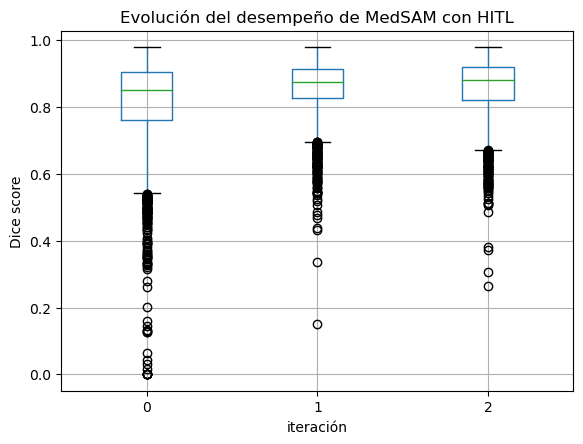

dice_score                                                    \
               count      mean       std       min       25%       50%   
iteration                                                                
0             2913.0  0.815259  0.133535  0.000000  0.760331  0.852459   
1             2913.0  0.858981  0.079786  0.150943  0.826087  0.876543   
2             2913.0  0.860555  0.083381  0.263158  0.820513  0.880141   

                               
                75%       max  
iteration                      
0          0.906188  0.978966  
1          0.913043  0.979798  
2          0.919540  0.979549

In [8]:
# Boxplot of Dice score for each iteration (all lesions)
performance_df.boxplot(column='dice_score', by='iteration')
plt.suptitle('')
plt.title('Evolución del desempeño de MedSAM con HITL')
plt.xlabel('iteración')
plt.ylabel('Dice score')
#plt.savefig(Path.cwd() / 'resources' / 'dice_boxplots_comparison.png', bbox_inches='tight')
plt.show()
display(performance_df[['dice_score', 'iteration']].groupby('iteration').describe())

In [9]:
iterations = performance_df['iteration'].unique()
iterations_count = len(iterations)
lesion_types_count = len(performance_df['label_description'].unique())
print(f"# iteraciones: {iterations_count}")
print(f"# tipos de lesión: {lesion_types_count}")

# iteraciones: 3
# tipos de lesión: 9


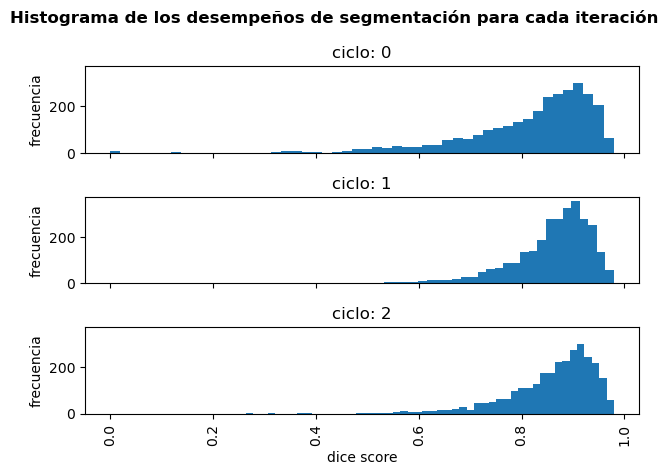

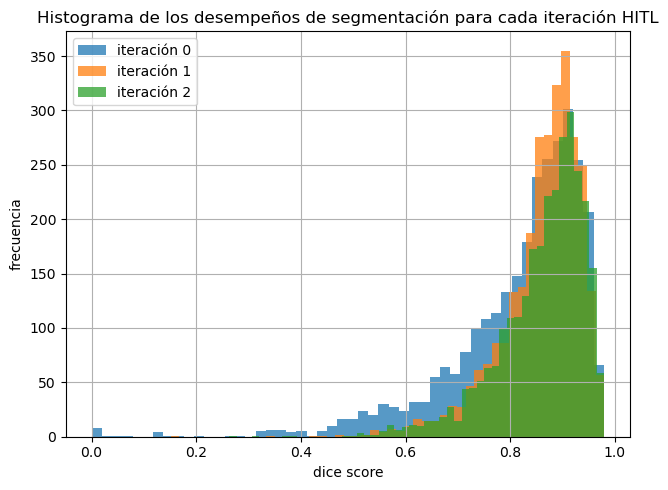

In [10]:
# Histogram of Dice score for each iteration (all lesions)
fig, ax = plt.subplots(nrows=iterations_count, ncols=1, sharex=True, sharey=True)
performance_df.hist(
    column='dice_score',
    by='iteration',
    bins=50,
    ax=ax
)
fig.suptitle('Histograma de los desempeños de segmentación para cada iteración', fontweight='bold')
for idx in range(iterations_count):
    ax[idx].set_ylabel('frecuencia')
    ax[idx].set_title(f"ciclo: {iterations[idx]}")
ax[-1].set_xlabel('dice score')
plt.tight_layout()
plt.show()
# Overlapped histograms
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5,5))
cmap = plt.get_cmap('tab10')
for it in iterations:
    performance_df[performance_df['iteration'] == it].hist(
        column='dice_score',
        bins=50,
        ax=ax,
        color=cmap(it),
        alpha=0.75,
        label=f"iteración {it}"
    )
ax.legend()
ax.set_title('Histograma de los desempeños de segmentación para cada iteración HITL')
ax.set_xlabel('dice score')
ax.set_ylabel('frecuencia')
plt.tight_layout()
#plt.savefig(Path.cwd() / 'resources' / 'overlapped_histograms.png', bbox_inches='tight')
plt.show()

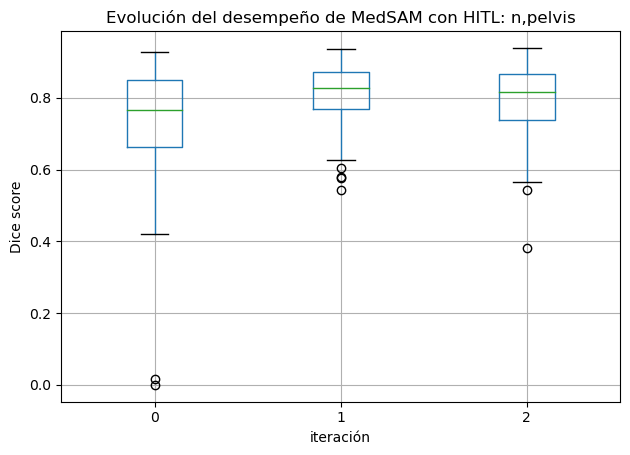

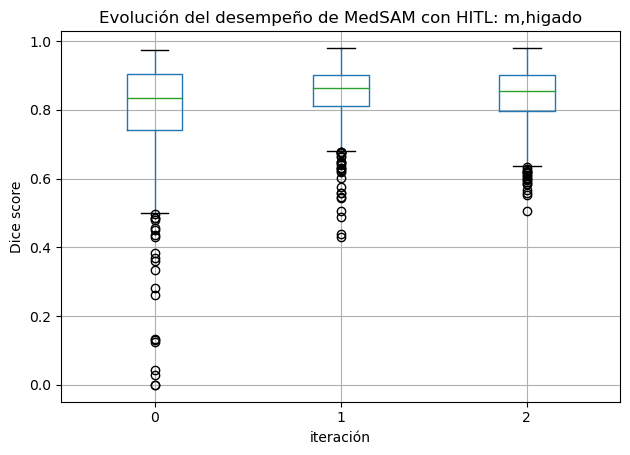

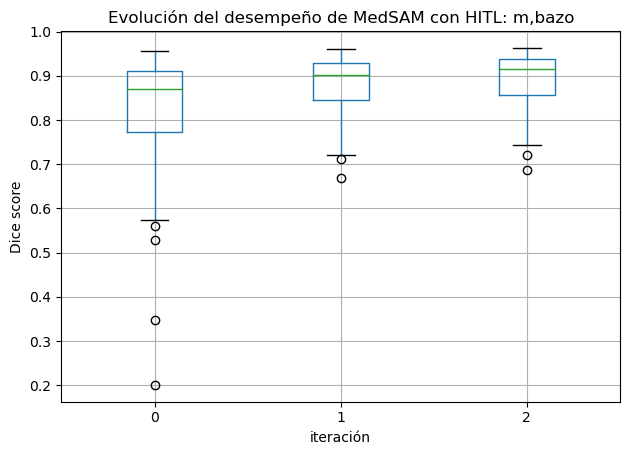

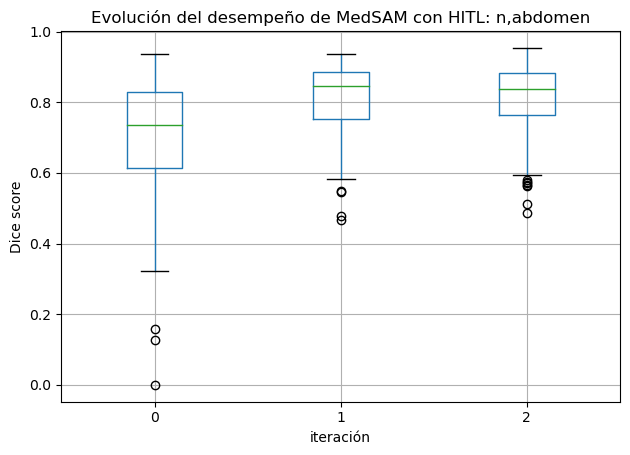

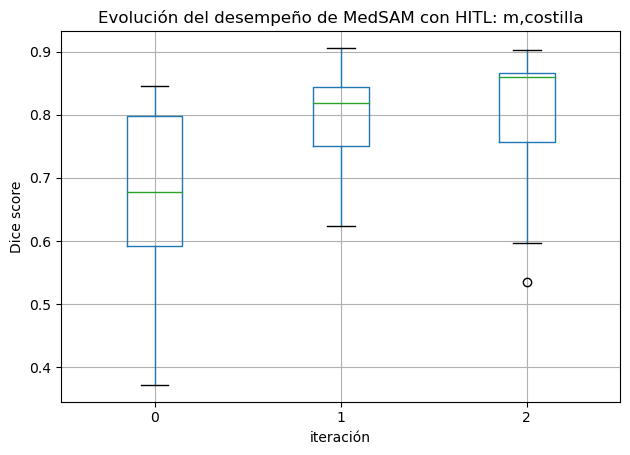

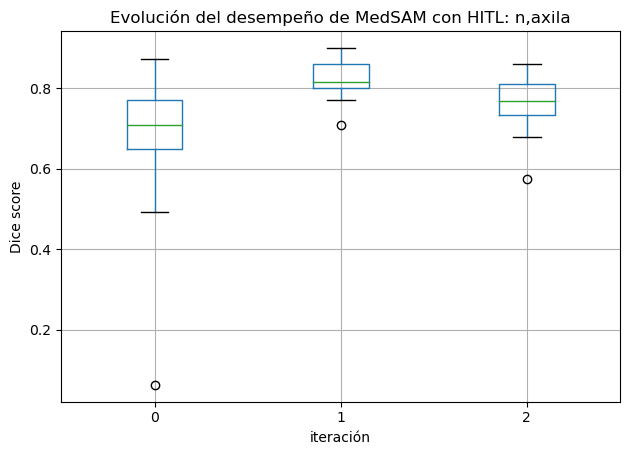

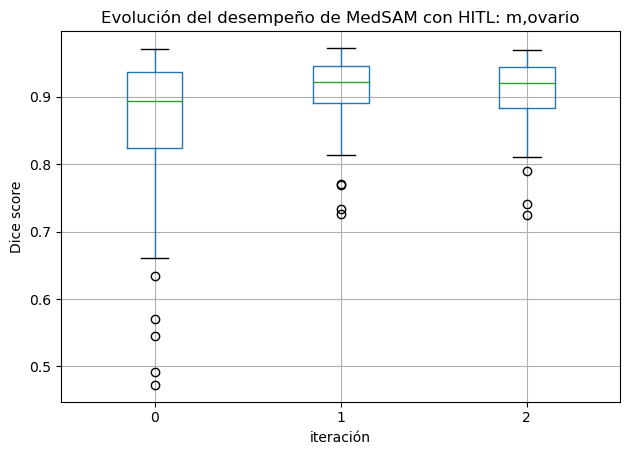

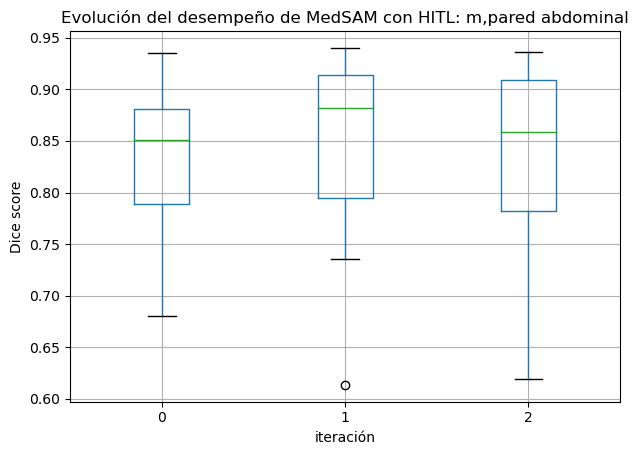

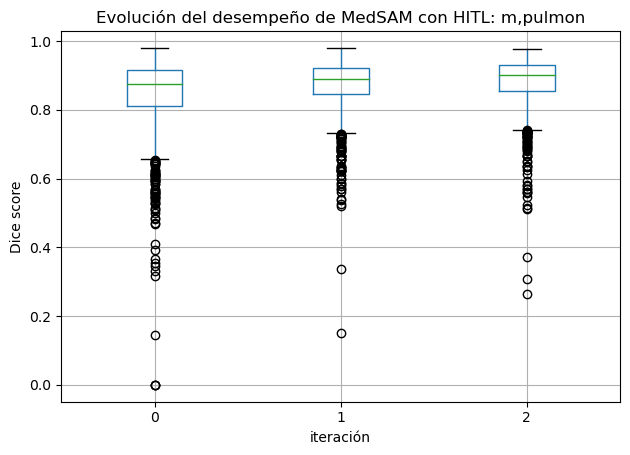

In [11]:
# Boxplot of Dice score for each iteration, dissagregated by lesion type
unique_lesions = list(performance_df['label_description'].unique())
for lesion in unique_lesions:
    performance_df[performance_df['label_description'] == lesion].boxplot(column='dice_score', by='iteration')
    plt.suptitle('')
    plt.title(f'Evolución del desempeño de MedSAM con HITL: {lesion}')
    plt.xlabel('iteración')
    plt.ylabel('Dice score')
    plt.tight_layout()
    plt.show()

In [12]:
display(performance_df.groupby(['label_description', 'iteration'])['dice_score'].describe())

count      mean       std       min       25%  \
label_description iteration                                                   
m,bazo            0            58.0  0.816580  0.148843  0.201117  0.773163   
                  1            58.0  0.876047  0.073537  0.669811  0.845220   
                  2            58.0  0.891694  0.063740  0.686981  0.855512   
m,costilla        0            12.0  0.675509  0.141777  0.372240  0.591673   
                  1            12.0  0.797267  0.076222  0.623963  0.749927   
                  2            12.0  0.796303  0.119557  0.535180  0.756589   
m,higado          0           735.0  0.801028  0.139761  0.000000  0.741490   
                  1           735.0  0.848606  0.078777  0.430769  0.812467   
                  2           735.0  0.841844  0.082135  0.506667  0.796555   
m,ovario          0            82.0  0.854532  0.111971  0.472681  0.824460   
                  1            82.0  0.909640  0.052021  0.726434  0.890764   
                  2            82.0  0.907793  0.050142  0.724684  0.883837   
m,pared abdominal 0            20.0  0.837178  0.069270  0.680556  0.788967   
                  1            20.0  0.850531  0.085483  0.613636  0.794356   
                  2            20.0  0.832498  0.092084  0.619565  0.782415   
m,pulmon          0          1550.0  0.850486  0.103201  0.000000  0.811918   
                  1          1550.0  0.874109  0.072562  0.150943  0.846599   
                  2          1550.0  0.882548  0.072096  0.263158  0.854839   
n,abdomen         0           312.0  0.706651  0.158035  0.000000  0.615047   
                  1           312.0  0.815944  0.091692  0.468111  0.753845   
                  2           312.0  0.812930  0.090324  0.487562  0.764924   
n,axila           0            18.0  0.674850  0.183188  0.062893  0.649506   
                  1            18.0  0.823833  0.048470  0.708661  0.800855   
                  2            18.0  0.761191  0.072962  0.573529  0.733111   
n,pelvis          0           126.0  0.737566  0.152950  0.000000  0.663456   
                  1           126.0  0.811385  0.082351  0.544118  0.769543   
                  2           126.0  0.796771  0.095976  0.380952  0.739074   

                                  50%       75%       max  
label_description iteration                                
m,bazo            0          0.870865  0.911705  0.955237  
                  1          0.902557  0.929354  0.959664  
                  2          0.915016  0.938811  0.962441  
m,costilla        0          0.678503  0.797481  0.845281  
                  1          0.818081  0.844530  0.905500  
                  2          0.859380  0.865935  0.902028  
m,higado          0          0.834437  0.903041  0.973047  
                  1          0.862745  0.901338  0.978932  
                  2          0.853503  0.902699  0.979549  
m,ovario          0          0.894224  0.937222  0.970973  
                  1          0.922395  0.945285  0.972091  
                  2          0.920503  0.944135  0.968731  
m,pared abdominal 0          0.850516  0.881024  0.934911  
                  1          0.881587  0.913454  0.939873  
                  2          0.858888  0.909293  0.936248  
m,pulmon          0          0.876688  0.917723  0.978966  
                  1          0.890289  0.922822  0.979798  
                  2          0.900409  0.929851  0.977675  
n,abdomen         0          0.736729  0.828709  0.935519  
                  1          0.845507  0.884795  0.937220  
                  2          0.836708  0.882568  0.953206  
n,axila           0          0.707176  0.771571  0.871429  
                  1          0.814034  0.859107  0.899083  
                  2          0.767409  0.810778  0.858586  
n,pelvis          0          0.766956  0.849749  0.927711  
                  1          0.827574  0.872821  0.935933  
                  2          0.817530  0.865769  0.938689

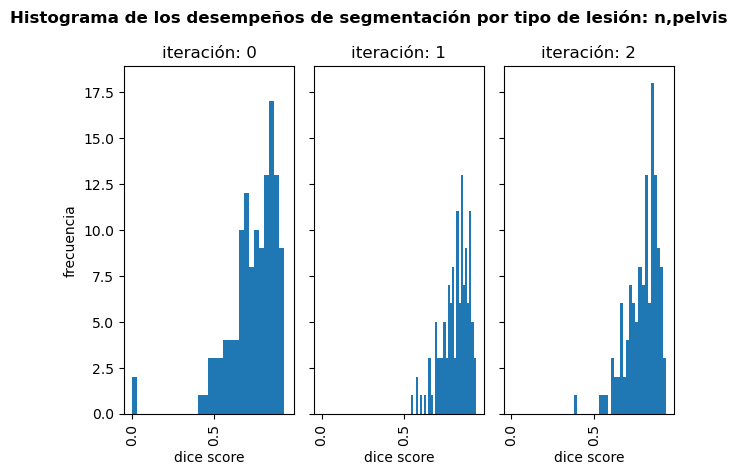

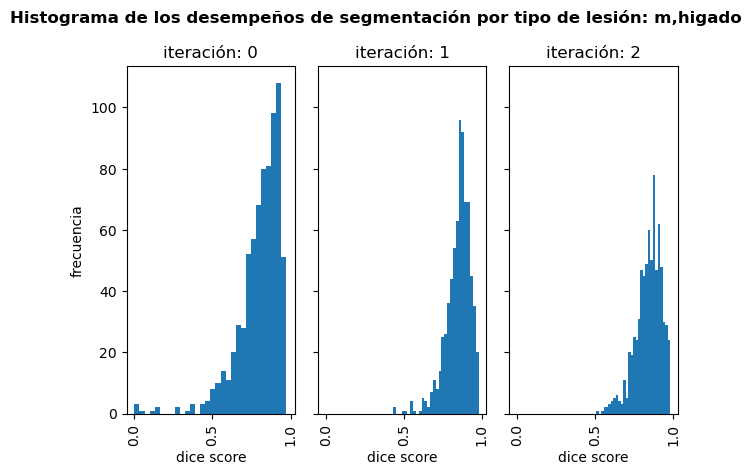

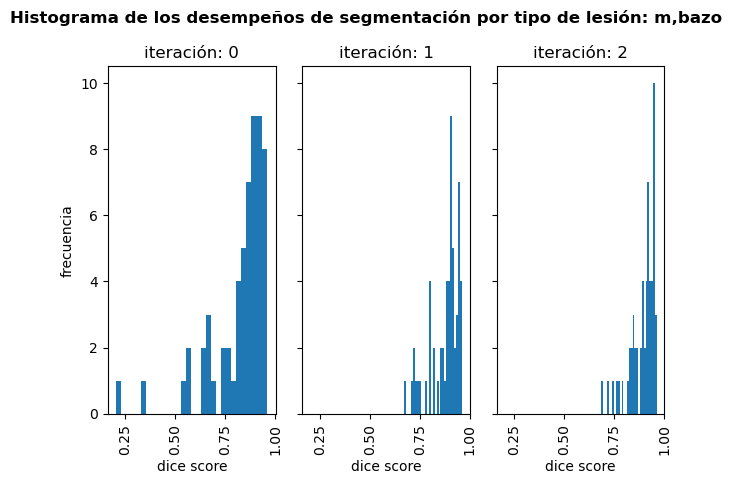

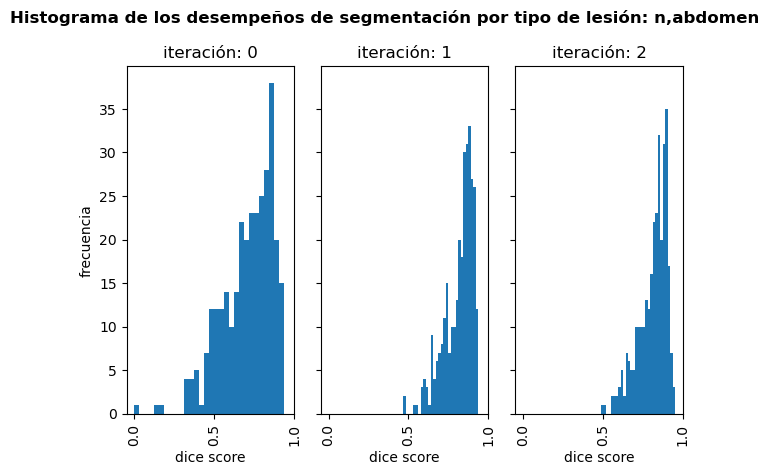

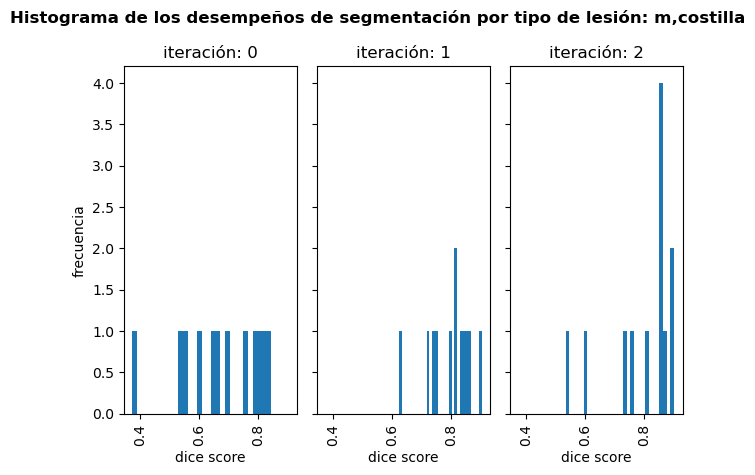

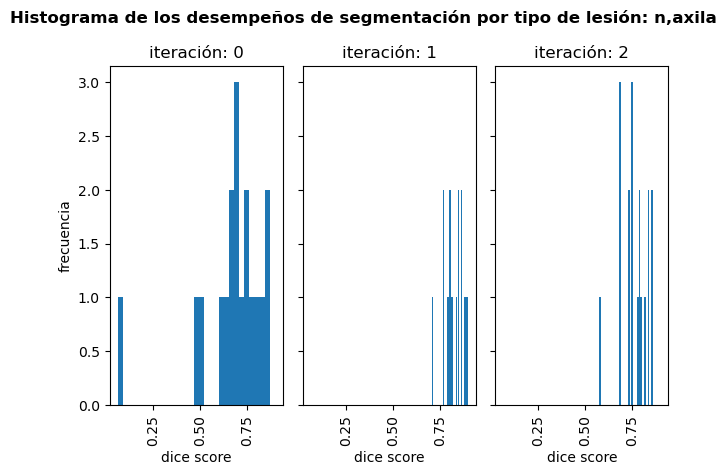

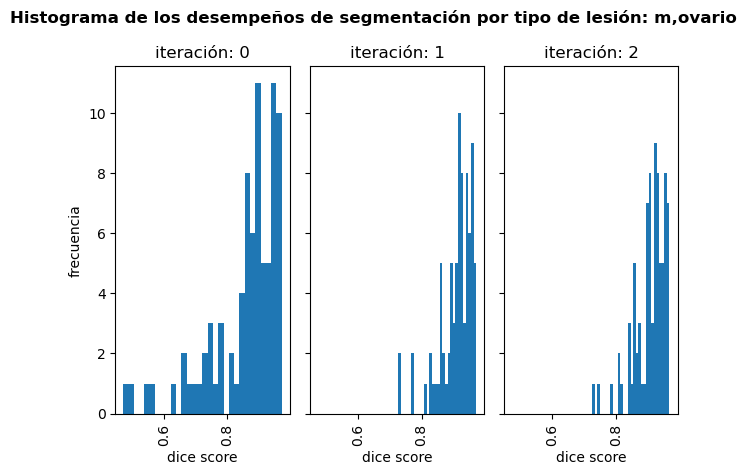

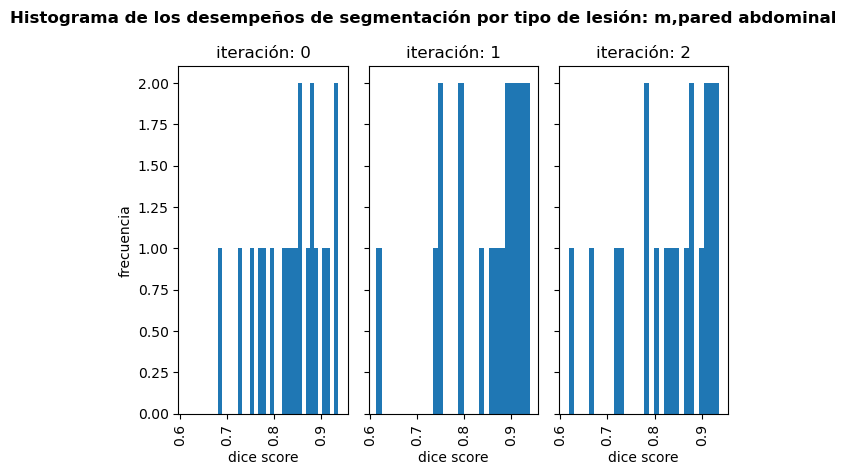

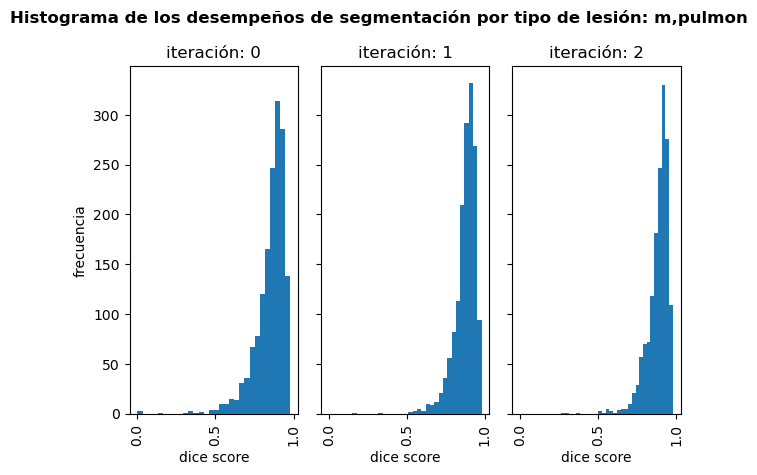

In [13]:
# Histogram of Dice score for each iteration, dissagregated by lesion type
for lesion in unique_lesions:
    fig, ax = plt.subplots(nrows=1, ncols=iterations_count, sharex=True, sharey=True)
    fig.suptitle(
        f'Histograma de los desempeños de segmentación por tipo de lesión: {lesion}',
        fontweight='bold'
    )
    performance_df[performance_df['label_description'] == lesion].hist(
        column='dice_score',
        by='iteration',
        bins=30,
        ax=ax
    )
    ax[0].set_ylabel('frecuencia')
    for idx in range(iterations_count):
        ax[idx].set_xlabel('dice score')
        ax[idx].set_title(f"iteración: {iterations[idx]}")
    plt.tight_layout()
    plt.show()

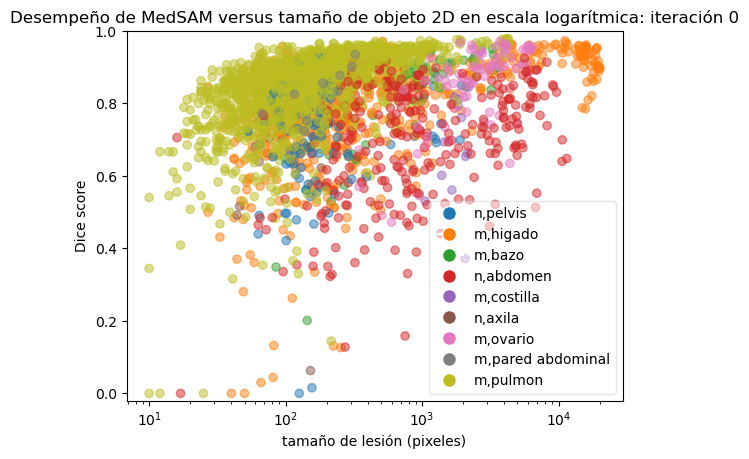

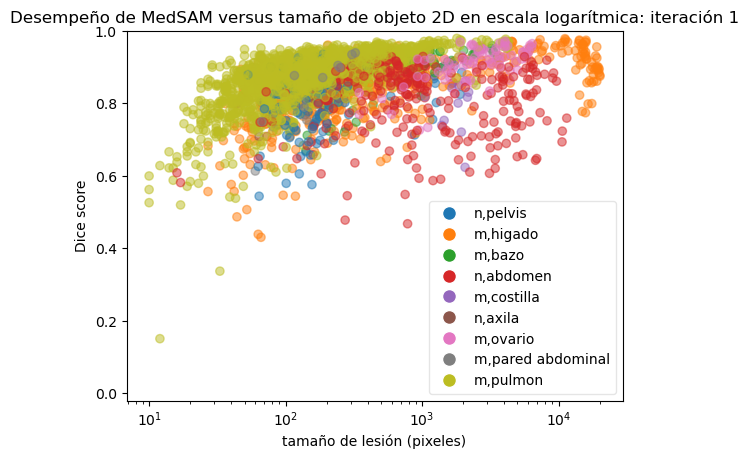

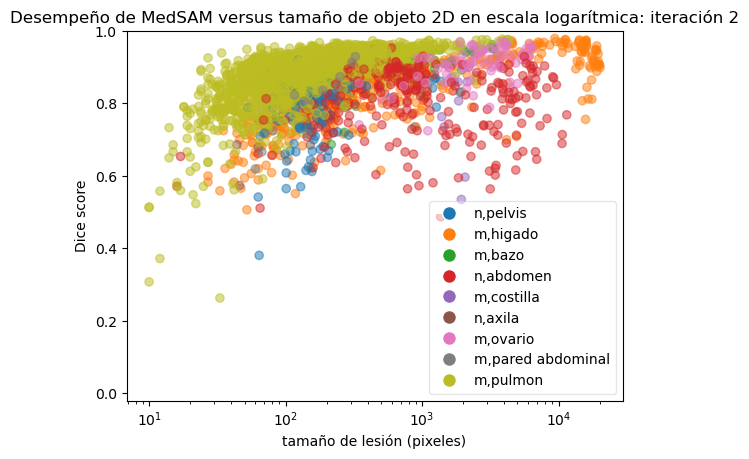

In [14]:
# Scatterplot of Dice versus object size, one plot for each iteration
iterations = list(performance_df['iteration'].unique())
# Add a color for each unique label description
cmap = plt.get_cmap('tab10')
color_mapping = {
    label: cmap(idx)
    for idx, label in enumerate(unique_lesions)
}
for iteration in iterations:
    _, ax = plt.subplots()
    filtered_df = performance_df[performance_df['iteration'] == iteration]
    colors = filtered_df["label_description"].map(color_mapping)
    ax.scatter(
        filtered_df['annotated_pixels'],
        filtered_df['dice_score'],
        c=colors.to_list(),
        label=filtered_df["label_description"],
        alpha=0.5
    )
    ax.set_xscale('log')
    ax.set_title(f'Desempeño de MedSAM versus tamaño de objeto 2D en escala logarítmica: iteración {iteration}')
    ax.set_xlabel('tamaño de lesión (pixeles)')
    ax.set_ylabel('Dice score')
    # Create legend labels based on unique values in 'label_description' column
    legend_labels = [
        Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color_mapping[value], label=value)
        for value in unique_lesions
    ]
    ax.legend(handles=legend_labels, framealpha=0.5)
    ax.set_ylim([-0.02, 1])
    #plt.savefig(
    #    Path.cwd() / "resources" / f"scatterplot_performance_vs_object_size_hitl_iteration_{iteration}.png",
    #    transparent=True,
    #    bbox_inches='tight'
    #)
    plt.show()

In [15]:
# Hypothesis testing for all dice scores
iteration_a_idx = 1
iteration_b_idx = 2
ttest_result, new_df = run_paired_t_test(
    performance_df,
    iteration_a_idx,
    iteration_b_idx
)
difference = new_df[f'dice_score_iteration_{iteration_b_idx}'] - new_df[f'dice_score_iteration_{iteration_a_idx}']
difference_sample_mean = np.mean(difference)
difference_sample_std = np.std(difference)
print(f"p value: {ttest_result.pvalue}")
print(f"difference sample mean: {difference_sample_mean}")
print(f"confidence interval: [{ttest_result.confidence_interval().low}, {ttest_result.confidence_interval().high}]")

p value: 0.05603432086364428
difference sample mean: 0.0015738255854744368
confidence interval: [-4.0546696461852194e-05, 0.003188197867410726]


In [16]:
# Hypothesis testing for scores grouped by lesion type
for lesion in unique_lesions:
    filtered_df = performance_df[performance_df['label_description'] == lesion]
    ttest_result, new_df = run_paired_t_test(
        filtered_df,
        iteration_a_idx,
        iteration_b_idx
    )
    difference = new_df[f'dice_score_iteration_{iteration_b_idx}'] - new_df[f'dice_score_iteration_{iteration_a_idx}']
    difference_sample_mean = np.mean(difference)
    difference_sample_std = np.std(difference)
    print(f"lesion: {lesion}")
    print(f"p value: {ttest_result.pvalue}")
    print(f"difference sample mean: {difference_sample_mean}")
    print(f"confidence interval: [{ttest_result.confidence_interval().low}, {ttest_result.confidence_interval().high}]")
    print("-"*70)

lesion: n,pelvis
p value: 0.0005951047073238702
difference sample mean: -0.014614408591543266
confidence interval: [-0.022822637565530518, -0.0064061796175560164]
----------------------------------------------------------------------
lesion: m,higado
p value: 0.00044458137695165835
difference sample mean: -0.006761541550384496
confidence interval: [-0.01052396456969632, -0.0029991185310726722]
----------------------------------------------------------------------
lesion: m,bazo
p value: 5.141006513664832e-05
difference sample mean: 0.01564698717823453
confidence interval: [0.008493509369847572, 0.022800464986621485]
----------------------------------------------------------------------
lesion: n,abdomen
p value: 0.16511917882916213
difference sample mean: -0.0030135607691803693
confidence interval: [-0.007275336697459157, 0.0012482151590984176]
----------------------------------------------------------------------
lesion: m,costilla
p value: 0.9630463552438194
difference sample mean: -

**Warning**: Existe una pequeña cantidad de ROIs (bounding boxes de objetos 2D) que están presentes en una iteración del HITL, pero no en las otras. Esta cantidad es del orden 1-5 ROIs.

**TODO**: Revisar dichos bounding boxes para cada iteración. Recordar que provienen del conjunto de test y de la ejecución del script `evaluate_CT_dataset.py` en [este repositorio](https://github.com/robertorojasp06/MedSAM).

In [17]:
# Get the dataframe with the performance difference between iterations
iterations = [0, 1]
pivot_df = performance_df[performance_df['iteration'].isin(iterations)].pivot(
    index=['bbox_original_fname', 'label_description', 'annotated_pixels'],
    columns='iteration',
    values='dice_score'
)
first_it_name = f"dice_iteration_{iterations[0]}"
second_it_name = f"dice_iteration_{iterations[1]}"
pivot_df.rename(
    columns={
        iterations[0]: first_it_name,
        iterations[1]: second_it_name
    },
    inplace=True
)
pivot_df['dice_difference'] = pivot_df[second_it_name] - pivot_df[first_it_name]
pivot_df.reset_index(inplace=True)
#pivot_df.to_csv(Path.cwd() / 'resources' / f'performance_difference_it{iterations[1]}_vs_it{iterations[0]}.csv', index=False)

# Evaluación de modelos CV en conjunto de test
- En esta sección se evalúa y compara los mejores modelos obtenidos en cada iteración de la Validación Cruzada, en relación a su desempeño de segmentación **sobre el conjunto de test**.

In [18]:
path_to_best_cv_models = [
    {
        "cv_iteration": 0,
        "path_to_performance": Path.cwd() / "resources" / "HITL-iteration-2" / "test-evaluation" / "performance_cv_iteration_0_MedSAM-ViT-B-20240729-2048.json"
    },
    {
        "cv_iteration": 1,
        "path_to_performance": Path.cwd() / "resources" / "HITL-iteration-2" / "test-evaluation" / "performance_cv_iteration_1_MedSAM-ViT-B-20240730-0847.json"
    },
    {
        "cv_iteration": 2,
        "path_to_performance": Path.cwd() / "resources" / "HITL-iteration-2" / "test-evaluation" / "performance_cv_iteration_2_MedSAM-ViT-B-20240730-1505.json"
    },
    {
        "cv_iteration": 3,
        "path_to_performance": Path.cwd() / "resources" / "HITL-iteration-2" / "test-evaluation" / "performance_cv_iteration_3_MedSAM-ViT-B-20240730-2036.json"
    },
    {
        "cv_iteration": 4,
        "path_to_performance": Path.cwd() / "resources" / "HITL-iteration-2" / "test-evaluation" / "performance_cv_iteration_4_MedSAM-ViT-B-20240731-0300.json"
    },
    {
        "cv_iteration": 5,
        "path_to_performance": Path.cwd() / "resources" / "HITL-iteration-2" / "test-evaluation" / "performance_cv_iteration_5_MedSAM-ViT-B-20240731-0835.json"
    },
    {
        "cv_iteration": 6,
        "path_to_performance": Path.cwd() / "resources" / "HITL-iteration-2" / "test-evaluation" / "performance_cv_iteration_6_MedSAM-ViT-B-20240731-1435.json"
    },
    {
        "cv_iteration": 7,
        "path_to_performance": Path.cwd() / "resources" / "HITL-iteration-2" / "test-evaluation" / "performance_cv_iteration_7_MedSAM-ViT-B-20240731-2035.json"
    }
]

In [19]:
def concatenate_cv_iteration_dfs(path_to_best_cv_models, keep_only_common_between_iterations=True):
    dfs = []
    for item in path_to_best_cv_models:
        with open(item['path_to_performance'], 'r') as file:
            df = pd.DataFrame(json.load(file)['bboxes'])
        df['cv_iteration'] = item['cv_iteration']
        dfs.append(df)
    concatenated_df = pd.concat(dfs, ignore_index=True).sort_values(by='cv_iteration')
    if keep_only_common_between_iterations:
        common_bboxes = set(concatenated_df['bbox_original_fname'])
        for iteration in concatenated_df['cv_iteration'].unique():
            common_bboxes = common_bboxes.intersection(set(concatenated_df[concatenated_df['cv_iteration'] == iteration]['bbox_original_fname']))
        concatenated_df = concatenated_df[concatenated_df['bbox_original_fname'].isin(common_bboxes)]
    return concatenated_df

In [20]:
# Concatenate performance from different CV iterations
best_models_performance_df = concatenate_cv_iteration_dfs(path_to_best_cv_models)
best_models_performance_df = add_patient_info_to_df(
    best_models_performance_df,
    path_to_patients,
    path_to_series
)
# Remove 2D objects with size smaller than "min_pixels_size"
best_models_performance_df = best_models_performance_df[best_models_performance_df["annotated_pixels"] >= min_size_pixels]

In [21]:
# Performance for each CV model grouped by patient
grouped = best_models_performance_df.groupby(['patient_code', 'diagnosis','cv_iteration'])['dice_score'].agg(['mean', 'std']).reset_index()
display(grouped)

,patient_code,diagnosis,cv_iteration,mean,std
0,2208,Cancer recto,0,0.871990,0.077452
1,2208,Cancer recto,1,0.870763,0.082585
2,2208,Cancer recto,2,0.867784,0.076937
3,2208,Cancer recto,3,0.871961,0.080415
4,2208,Cancer recto,4,0.870201,0.076566
5,2208,Cancer recto,5,0.867494,0.079307
6,2208,Cancer recto,6,0.865534,0.088745
7,2208,Cancer recto,7,0.873004,0.078434
8,10976,Cancer vesicula biliar,0,0.818397,0.094009
9,10976,Cancer vesicula biliar,1,0.809491,0.103351


In [28]:
# Mean performance for each CV model
grouped = best_models_performance_df.groupby(['cv_iteration'])['dice_score'].agg(['mean', 'std']).reset_index()
display(grouped)

,cv_iteration,mean,std
0,0,0.860478,0.083525
1,1,0.858626,0.090713
2,2,0.863281,0.083601
3,3,0.861817,0.085419
4,4,0.856948,0.091458
5,5,0.856386,0.085636
6,6,0.862892,0.088323
7,7,0.862904,0.087685


In [22]:
# Performance of default MedSAM grouped by patient
grouped = performance_df[performance_df['iteration'] == 0].groupby(['patient_code', 'diagnosis'])['dice_score'].agg(['mean', 'std']).reset_index()
display(grouped)

,patient_code,diagnosis,mean,std
0,2208,Cancer recto,0.824347,0.130005
1,10976,Cancer vesicula biliar,0.705200,0.159792
2,10978,Cancer colon,0.831756,0.119860
3,10979,Cancer gastrico,0.851130,0.104907
4,10980,Cancer vejiga,0.734733,0.157762
5,10991,Melanoma,0.674850,0.183188


# Distribución de los datos por conjunto y diagnóstico

In [23]:
path_to_cv_splits = Path.cwd() / "resources" / "HITL-iteration-2" / "model-selection" / "splits.csv"
splits_df = pd.read_csv(path_to_cv_splits).drop_duplicates(
    subset=['filename'],
    ignore_index=True
)
unique_test_bboxes_df = performance_df.drop_duplicates(
    subset=['bbox_original_fname'],
    ignore_index=True
)
patients_df = pd.read_csv(path_to_patients)
splits_df = pd.merge(
    splits_df,
    patients_df[['id_proyecto', 'code', 'sexo', 'edad', 'diagnóstico']],
    how='inner',
    left_on='patient_code',
    right_on='code'
)
splits_df.drop(columns=['patient_code'], inplace=True)
splits_df.rename(
    columns={
        'id_proyecto': 'patient_id',
        'code': 'patient_code',
        'sexo': 'sex',
        'edad': 'age',
        'diagnóstico': 'diagnosis'
    },
    inplace=True
)
selected_columns = ['patient_code', 'diagnosis']
train_patients = splits_df.drop_duplicates(subset=['patient_code'])[selected_columns]
train_patients['subset'] = 'train'
test_patients = unique_test_bboxes_df.drop_duplicates(subset=['patient_code'])[selected_columns]
test_patients['subset'] = 'test'
patients_concatenated_df = pd.concat([train_patients, test_patients], ignore_index=True)
display(patients_concatenated_df)

,patient_code,diagnosis,subset
0,3,Cancer mama,train
1,6,Cancer colon,train
2,2,Cancer gastrico,train
3,10972,Cancer gastrico,train
4,10973,Cancer recto,train
5,1,Cancer gastrico,train
6,10974,Cancer colon,train
7,14,Cancer pulmon,train
8,10978,Cancer colon,test
9,10991,Melanoma,test


In [24]:
def plot_pie_chart(df, color_map=None, title='dataset_distribution.png'):
    # Group the dataframe by the 'subset' column
    grouped = df.groupby('subset')

    if not color_map:
        # Create a dictionary to store the mapping of 'diagnosis' values to colors
        color_map = {}

        # Iterate over the groups to create consistent color mapping
        for subset, data in grouped:
            # Get unique 'diagnosis' values for the subset
            unique_diagnosis = data['diagnosis'].unique()

            # Check if colors are already assigned for 'diagnosis' values
            for diagnosis in unique_diagnosis:
                if diagnosis not in color_map:
                    # Assign a color to the 'diagnosis' value if not already assigned
                    color_map[diagnosis] = plt.cm.tab20(len(color_map))

    _, axes = plt.subplots(nrows=1, ncols=len(df['subset'].unique()), figsize=(10,4))
    # Plot a pie chart for each subset
    for subset, data in grouped:
        idx = 0 if subset == 'train' else 1
        # Get value counts of 'diagnosis' for the subset
        value_counts = data['diagnosis'].value_counts()

        # Create a list of colors for 'diagnosis' values based on the color map
        colors = [color_map[diagnosis] for diagnosis in value_counts.index]

        # Plot pie chart
        axes[idx].pie(
            value_counts,
            labels=value_counts.index,
            colors=colors,
            autopct=lambda x: f'{x/100 * sum(value_counts.to_list()):.0f}',
            startangle=90
        )

        # Add title
        axes[idx].set_title(f"{'Entrenamiento' if subset == 'train' else 'Test'}", fontweight='bold')

    # Save fig
    plt.tight_layout()
    #plt.savefig(Path.cwd() / "resources" / title)
    # Show plot
    plt.show()

In [25]:
# Get unique colors
color_map = {}
unique_diagnosis = patients_concatenated_df['diagnosis'].unique()

# Check if colors are already assigned for 'diagnosis' values
for diagnosis in unique_diagnosis:
    if diagnosis not in color_map:
        # Assign a color to the 'diagnosis' value if not already assigned
        color_map[diagnosis] = plt.cm.tab20(len(color_map))

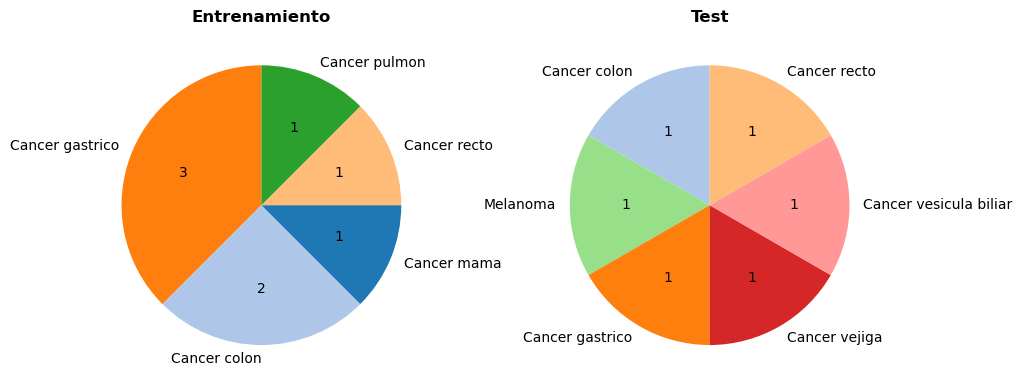

In [26]:
# Patients distribution
plot_pie_chart(patients_concatenated_df, color_map=color_map, title='patients_distribution.png')

,series_uuid,patient_code,diagnosis,subset
0,1.3.12.2.1107.5.1.4.83504.30000019041511214045...,3,Cancer mama,train
1,1.3.12.2.1107.5.1.4.83504.30000019103012204275...,3,Cancer mama,train
2,1.3.12.2.1107.5.1.4.83504.30000019070312170000...,3,Cancer mama,train
3,1.3.12.2.1107.5.1.4.83504.30000021011202081810...,6,Cancer colon,train
4,1.3.12.2.1107.5.1.4.83504.30000021011202081810...,6,Cancer colon,train
5,1.3.12.2.1107.5.1.4.83504.30000021031714114711...,6,Cancer colon,train
6,1.3.12.2.1107.5.1.4.83504.30000021031714114711...,6,Cancer colon,train
7,1.3.12.2.1107.5.1.4.83504.30000020102916421550...,6,Cancer colon,train
8,1.3.12.2.1107.5.1.4.83504.30000020102916421550...,6,Cancer colon,train
9,1.3.12.2.1107.5.1.4.83885.30000022082507483231...,2,Cancer gastrico,train


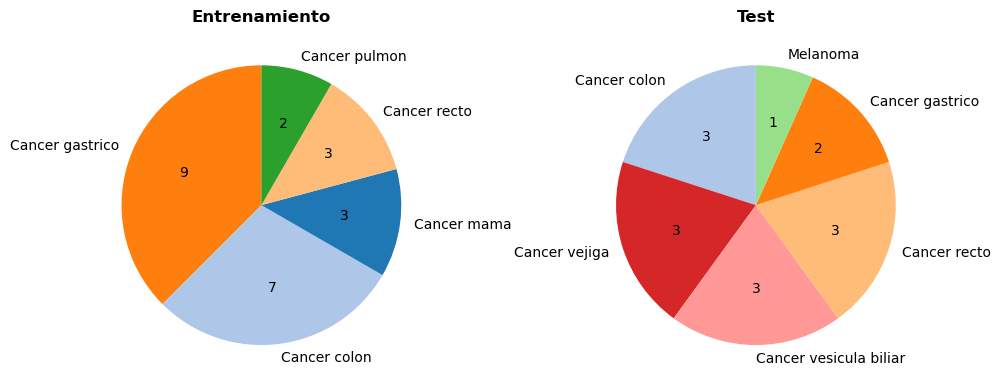

In [27]:
# CTs distribution
selected_columns = ['series_uuid', 'patient_code', 'diagnosis']
train_cts_df = splits_df.drop_duplicates(subset=['series_uuid'], ignore_index=True)[selected_columns]
train_cts_df['subset'] = 'train'
test_cts_df = unique_test_bboxes_df.drop_duplicates(subset=['study'], ignore_index=True)[selected_columns]
test_cts_df['subset'] = 'test'
cts_concatenated_df = pd.concat([train_cts_df, test_cts_df], ignore_index=True)
display(cts_concatenated_df)
plot_pie_chart(cts_concatenated_df, color_map=color_map, title='cts_distribution.png')